# FRB FBI: Teaching a Neural Network to Distinguish Between Fast Radio Bursts and Radio Frequency Interference

Fast radio bursts (FRBs) are highly energetic radio pulses whose origin is still hotly debated. Neutron stars? Supernovae? Aliens? **Nobody knows!** The image below ([UTMOST collaboration](https://astronomy.swin.edu.au/research/utmost/?p=1508)) is an example spectrogram of a dedispersed FRB.

<center>
<img src=http://astronomy.swin.edu.au/research/utmost/wp-content/uploads/2018/10/frb181017.png>
</center>

At these frequencies, however, a major problem for current detection software is radio frequency interference (RFI). Emissions like WiFi in the image below ([Miller et al. 2007](https://www.researchgate.net/publication/4281289_Service_Discovery_and_Device_Identification_in_Cognitive_Radio_Networks)) would very likely be mistaken for an FRB.
<center>
<img src=https://www.researchgate.net/profile/Wenyuan_Xu/publication/4281289/figure/fig3/AS:671515225911303@1537113114264/Spectrogram-of-the-ISM-band-centered-at-2467-MHz-and-spanning-4-MHz.png>
</center>

## Objective
To circumvent this issue, we will use neural networks to train a classification model on how to distinguish between FRBs and RFI given a frequency-time array. Due to the unpredictability of FRBs (they come once are are usually never seen again), there are only a few FRB observations, leading to a miniscule training set.

Expanding the training set to an appropriate size for the neural network to learn requires simulations, and we follow the simulation process outlined in [Connor & van Leeuwen (2018)](https://arxiv.org/pdf/1803.03084.pdf). This appropriately large dataset will then be used to train the model, and we will show that its performance is quite promising!

The end goal is to be able to whittle down a large data set of proposed FRB candidates to where it's feasible enough for a humans to sort through the and find FRBs in the reduced collection of images.

### Basic Imports

In [1]:
import sys, os
import numpy as np
from scipy.signal import gaussian, fftconvolve # FRB simulation
from time import time
from tqdm import tqdm, trange  # progress bar
import argparse  # to parse arguments in command line
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

# making a neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Nadam
from keras.models import load_model

# plotting!
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.ranges import Range1d, DataRange1d # used to flip axes for magnitude scale
from bokeh.palettes import Category10, Viridis256

output_notebook() # render bokeh plots within the notebook

Using TensorFlow backend.


Loading BokehJS ...

### Plotting functions

In [2]:
# setting matplotlib default font size
mpl.rcParams['font.size'] = 18

# setting bokeh colors
colors = Category10[5]
colors = {'blue': colors[0], 'orange': colors[1], 'green': colors[2], 'red': colors[3], 'purple': colors[4]}

# general function to create sweet, sweet Bokeh plots
def bokeh_plot(x, y, plot_type='scatter', title=None, x_label=None, y_label=None, height=500, width=900, 
               flipped_x=False, flipped_y=False, size=5, line_width=2, line_style='solid', x_axis_type='linear', y_axis_type='linear', 
               color='blue', line_alpha=0.8, fill_alpha=0.7, legend=None, show_plot=False):  
    
    plot = figure(title = title, x_axis_label = x_label, y_axis_label = y_label, 
                  x_axis_type = x_axis_type, y_axis_type = y_axis_type, plot_width = width, 
                  plot_height = height, x_range = DataRange1d(flipped = flipped_x), 
                  y_range = DataRange1d(flipped = flipped_y))
    
    if plot_type == 'scatter':
        plot.circle(x, y, size=size, line_alpha=0.8, fill_color=colors[color], 
                    line_color=colors[color], fill_alpha=fill_alpha, legend=legend)
    elif plot_type == 'line':
        plot.line(x, y, line_width=line_width, line_color=colors[color], line_dash=line_style, 
                  line_alpha=line_alpha, legend=legend)
    else:
        return "Not a valid plot type"
    
    if show_plot:
        show(plot)
        
    return plot

# plot a histogram in bokeh
def histogram(data, title=None, x_label=None, y_label=None, normed=False, bins=20, height=500, width=900, 
              color='blue', alpha=0.6, show_plot=False):
    
    plot = figure(title=title, x_axis_label=x_label, y_axis_label=y_label, plot_width=width, plot_height=height)
    
    # normalize that histogram yourself, because numpy can't do it
    if normed:
        hist, edges = np.histogram(data, bins=bins)
        hist = hist / np.sum(hist) * 100
    else:
        hist, edges = np.histogram(data, bins=bins)
        
    plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], color=colors[color], alpha=alpha)
    
    if show_plot:
        show(plot)
        
    return plot

## Simulating FRBs: The Math

To create FRBs, Connor & van Leeuwen (2018) begin with a 1D Gaussian profile and clone it into a second dimension such that each profile is a 1D Gaussian. They then create an exponential scattering profile, where light at lower frequencies tends to be scattered more than that at higher frequencies by the intergalactic medium. The scattering is defined by the following equations:

\begin{align}
s(t) = \frac{1}{\tau_\nu} e^{-t/\tau_\nu} \\
\tau_\nu = \tau_0 \left(\frac{\nu}{\nu_{ref}}\right)^{-4}
\end{align}

Here, $\tau_\nu$ is the scattering timescale at frequency $\nu$, with $\nu_{ref}$ acting as a reference frequency. 

Finally, we add frequency scintillation, which is caused by rapid variations in the refractive index of the medium, mainly in the electron density ([Acharya 2014](https://www.sciencedirect.com/science/article/pii/B9780127999494000075)). This causes the intensity of the FRB to oscillate, and it is approximated by the *positive* half of a cosine function with a random phase.

\begin{align}
A = \cos(2 \pi N_{scint} (\nu\ /\ \nu_{ref})^{-2} + \phi_{scint})
\end{align}

where $A$ is the amplitude of the pulse, $N_{scint}$ is the number of scintillations (uniformly distributed from 0 to 10), and $\phi_{scint}$ is some random phase (uniformly distributed from 0 to 1).

*Figures on each step of the simulation will be provided shown after the implementation.*

## Simulating FRBs: The Code

Each FRB will actually be part of a Class, wherein each instance will contain useful information like the frequency range, maximum time duration, and the background array where the FRB will be injected. The simulation code itself is a modified version of Liam Connor's own [FRB simulation work](https://github.com/liamconnor/single_pulse_ml/blob/master/single_pulse_ml/simulate_frb.py).

The following table consists of the values used to generate FRBs based on the mathematical variables defined above.

| Variable | Value |
| --- | --- |
| array shape | (64, 256) |
| max duration (millis) | 4 |
| $\tau_\nu$ (millis) | 0.1 |
| $\nu_{min}$ (MHz) | 600 |
| $\nu_{max}$ (MHz) | 2100 |
| $\nu_{ref}$ (MHz) | 1350 |

In [3]:
class SimulatedFRB(object):
    """ Class to generate a realistic fast radio burst and 
    add the event to data, including scintillation and 
    temporal scattering. @source liamconnor
    """
    def __init__(self, shape=(64, 256), f_low=800, f_high=2000, f_ref=1350, 
                bandwidth=1500, max_width=4, tau=0.1):
        assert type(shape) == tuple and len(shape) == 2, "shape needs to be a tuple of 2 integers"        
        self.shape = shape

        # reference frequency (MHz) of observations
        self.f_ref = f_ref
        
        # maximum width of pulse, high point of uniform distribution for pulse width
        self.max_width = max_width 
        
        # number of bins/data points on the time (x) axis
        self.nt = shape[1] 
        
        # frequency range for the pulse, given the number of channels
        self.frequencies = np.linspace(f_ref - bandwidth // 2, f_ref + bandwidth // 2, shape[0])
        
        # lowest and highest frequencies in which to inject the FRB (default is for GBT)
        self.f_low = f_low
        self.f_high = f_high

        # where the pulse will be centered on the time (x) axis
        self.t0 = np.random.randint(-shape[1] + max_width, shape[1] - max_width) 

        # scattering timescale (milliseconds)
        self.tau = tau

        # randomly generated SNR and FRB generated after calling injectFRB()
        self.SNR = None
        self.FRB = None

        '''Simulates background noise similar to the .ar 
        files. Backgrounds will be injected with FRBs to 
        be used in classification later on.'''
        self.background = np.random.randn(*self.shape)

    def gaussian_profile(self):
        """Model pulse as a normalized Gaussian."""
        t = np.linspace(-self.nt // 2, self.nt // 2, self.nt)
        g = np.exp(-(t / np.random.randint(1, self.max_width))**2)
        
        if not np.all(g > 0):
            g += 1e-18

        # clone Gaussian into 2D array with NFREQ rows
        return np.tile(g, (self.shape[0], 1))
    
    def scatter_profile(self):
        """ Include exponential scattering profile."""
        tau_nu = self.tau * (self.frequencies / self.f_ref) ** -4
        t = np.linspace(0, self.nt//2, self.nt)

        prof = np.exp(-t / tau_nu.reshape(-1, 1)) / tau_nu.reshape(-1, 1)
        prof /= np.max(prof, axis=1).reshape(-1, 1)
        #return prof / np.max(prof, axis=1).reshape(-1, 1)
        return np.roll(prof, self.shape[1] // 2, axis=1)

    def pulse_profile(self):
        """ Convolve the gaussian and scattering profiles
        for final pulse shape at each frequency channel.
        """
        gaus_prof = self.gaussian_profile()
        scat_prof = self.scatter_profile()
        
        # convolve the two profiles for each frequency
        # pulse_prof = np.array([fftconvolve(gaus_prof[i], scat_prof[i])[:self.nt] for i in np.arange(self.shape[0])])
        pulse_prof = fftconvolve(gaus_prof, scat_prof, axes=1, mode='same')

        # normalize! high frequencies should have narrower pulses
        pulse_prof /= np.trapz(pulse_prof, axis=1).reshape(-1, 1)
        return pulse_prof

    def scintillate(self):
        """Approximate frequency scintillation as the positive half of 
        a cosine function. Randomize the phase and decorrelation bandwidth.
        """
        # Make location of peaks / troughs random
        scint_phi = np.random.rand()

        # Make number of scintils between 0 and 10
        nscint = np.exp(np.random.uniform(np.log(1e-3), np.log(7)))

        # set number of scintillations to 0 if it's below 1
        if nscint < 1:
            nscint = 0
        
        # make envelope a cosine function
        envelope = np.cos(2 * np.pi * nscint * (self.frequencies / self.f_ref)**-2 + scint_phi)
        
        # set all negative elements to zero and add small factor
        envelope[envelope < 0] = 0
        envelope += 0.1

        # add scintillation to pulse profile
        pulse = self.pulse_profile()
        pulse *= envelope.reshape(-1, 1)
        self.FRB = pulse

    def roll(self):
        """Move FRB to random location of the time axis (in-place),
        ensuring that the shift does not cause one end of the FRB
        to end up on the other side of the array."""
        bin_shift = np.random.randint(low = -self.shape[1] // 2 + self.max_width,
                                      high = self.shape[1] // 2 - self.max_width)
        self.FRB = np.roll(self.FRB, bin_shift, axis=1)

    def fractional_bandwidth(self, frac_low=0.5, frac_high=0.9):
        """Cut some fraction of the full pulse out."""
        # Fraction of frequency (y) axis for the signal
        frac = np.random.uniform(frac_low, frac_high)
        nchan = self.shape[0]

        # collect random fraction of FRB and add to background
        stch = np.random.randint(0, nchan * (1 - frac))
        slice_freq = slice(stch, int(stch + (nchan * frac)))
        slice_FRB = np.copy(self.FRB[slice_freq])
        self.FRB[:, :] = 1e-18
        self.FRB[slice_freq] = slice_FRB

    def sample_SNR(self, SNRmin=8, SNR_sigma=1.0, SNRmax=30):
        """Sample peak SNR from log-normal distribution and throw
        out any value greater than SNRmax."""
        if SNRmin < 0:
            raise ValueError('Minimum SNR cannot be negative')
        if SNRmin > SNRmax:
            raise ValueError('SNRmin cannot be greater than SNRmax')

        random_SNR = SNRmin + np.random.lognormal(mean=1.0, sigma=SNR_sigma)
        if random_SNR < SNRmax:     
            self.SNR = random_SNR
            return random_SNR
        else:
            return self.sample_SNR(SNRmin, SNR_sigma, SNRmax)

    def normalize_background(self, background):
        """Normalize the background array so each row sums up to 1"""
        background_row_sums = np.trapz(background, axis=1)[:, None]
        normed_background = np.divide(background, background_row_sums, out=np.zeros_like(background),
                                    where=background_row_sums > 0)

        self.background = normed_background
        return normed_background

    def injectFRB(self, SNR, background=None):
        """Inject FRB into the background"""
        if background is None:
            background = self.normalize_background(self.background)

        # get 1D noise and multiply signal by given SNR
        noise_profile = np.mean(background, axis=0)
        peak_value = SNR * np.std(noise_profile)
        profile_FRB = np.mean(self.FRB, axis=0)
        
        # make a signal with given SNR
        signal = self.FRB * (peak_value / np.max(profile_FRB))

        # zero out the FRB channels that are low powered on the telescope
        signal[(self.frequencies < self.f_low) | (self.frequencies > self.f_high), :] = 0

        return background + signal

    def simulateFRB(self, background=None, SNRmin=8, SNR_sigma=1.0, SNRmax=15):
        """Combine everything together and inject the FRB into a
        background array of Gaussian noise for the simulation. After
        this method works and is detected by the neural network, proceed
        to inject the FRB into the actual noise files given by psrchive."""
        if background is None:
            background = self.background

        # Create the FRB
        self.scintillate() # make the pulse profile with scintillation
        self.roll() # move the FRB around freq-time array
        self.fractional_bandwidth() # cut out some of the bandwidth
        self.sample_SNR(SNRmin, SNR_sigma, SNRmax) # get random SNR

        # normalize background array
        normed_background = self.normalize_background(background)
        
        # add to normalized background
        self.simulatedFRB = self.injectFRB(background=normed_background, SNR=self.SNR)

## Simulating FRBs: The Plots

We now visualize each step of the simulation. The convenience function below will plot a frequency-time array of a specified pulse, as well as several one-dimensional profiles corresponding to the lowest, middle, and highest frequencies in the simulated bandwidth.

Units for intensity in the 1D profiles are *arbitrary*, because we will use the random SNR of a pulse to scale with the background noise, whatever the units of noise will be.

In [21]:
def plot_simulation_steps(prof_name):
    """Plot a chosen step of the simulation."""
    np.random.seed(175)
    event = SimulatedFRB()
    event.scintillate()

    profiles = {'Gaussian Profile': event.gaussian_profile(),
                'Scatter Profile': event.scatter_profile(),
                'Pulse (No Scintillation)': event.pulse_profile(),
                'Pulse (With Scintillation)': np.copy(event.FRB)}
    
    # plot the simulation steps depending on selected profile
    fig_prof, ax_prof = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
    freq_extent = [0, event.nt, event.frequencies[0], event.frequencies[-1]]

    # plotting the data (frequency-time) array
    ax_prof[0].imshow(profiles[prof_name], origin='lower', extent=freq_extent, aspect='auto')
    ax_prof[0].set(title=prof_name, xlabel='time (ms)', ylabel='frequency (MHz)')

    # plot 1D profile from the top, middle, and bottom of the array
    ax_prof[1].plot(profiles[prof_name][0], linewidth=2, label=f'{int(event.frequencies[0])} MHz')
    ax_prof[1].plot(profiles[prof_name][len(prof_name) // 2], linewidth=2,
                 label=f'{int(event.frequencies[len(event.frequencies) // 2])} MHz')
    ax_prof[1].plot(profiles[prof_name][-1], linewidth=2, label=f'{int(event.frequencies[-1])} MHz')
    ax_prof[1].set(title=f"1D {prof_name}", xlabel='time (ms)', ylabel='intensity (arbitrary)')

    # give it a legend
    ax_prof[1].legend()

    # make plot spacing all nice
    fig_prof.tight_layout()
    fig_prof.subplots_adjust(hspace=0.5)

First, we begin with the Gaussian profile, which is just a 1D Gaussian cloned for every row in the array.

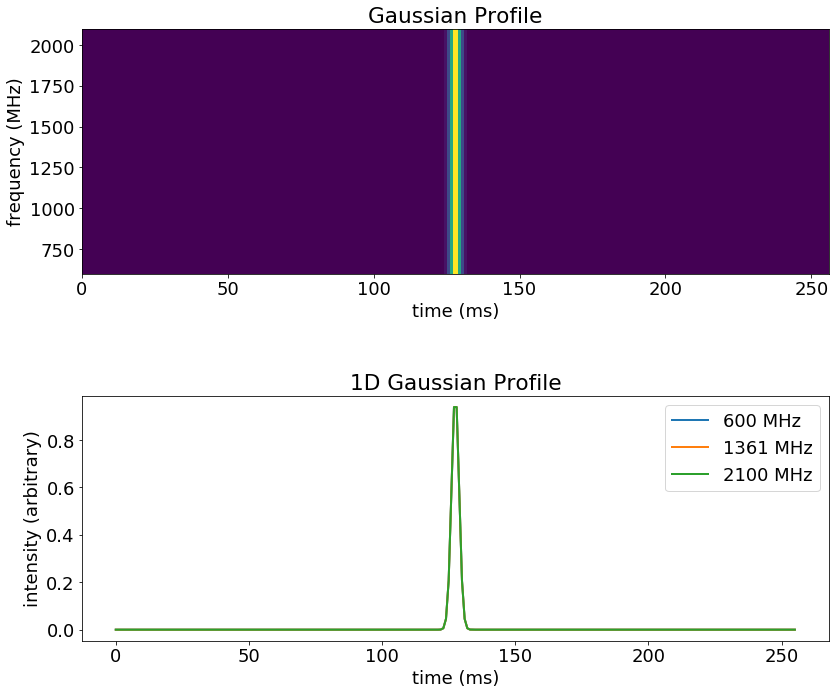

In [22]:
plot_simulation_steps('Gaussian Profile')

Next comes the exponential scatter profile.

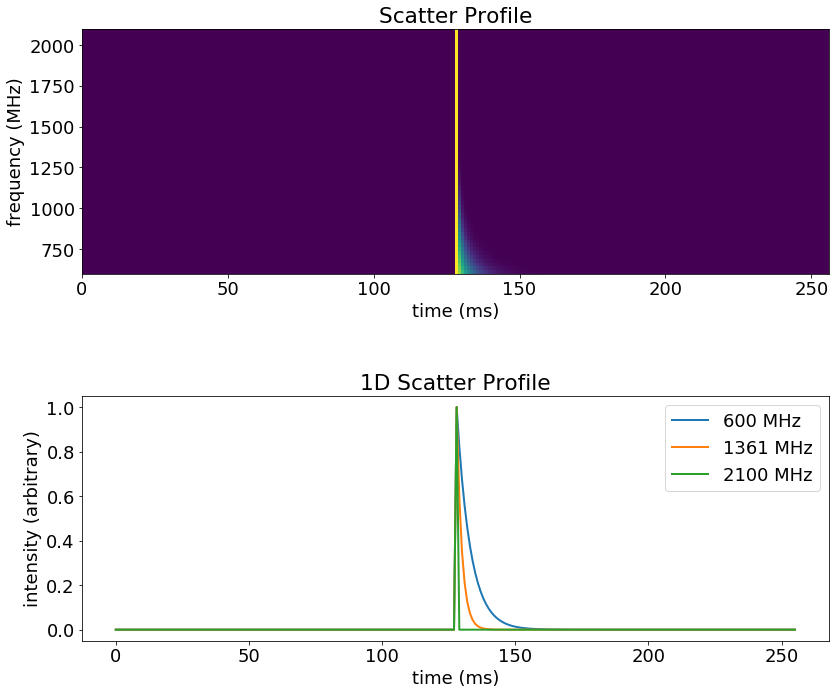

In [23]:
plot_simulation_steps('Scatter Profile')

As you can see, the profile drops off the steepest at the highest frequency, and the exponential tail is more drawn out as the frequency decreases.

We convolve the two profiles to obtain the non-scintillated pulse.

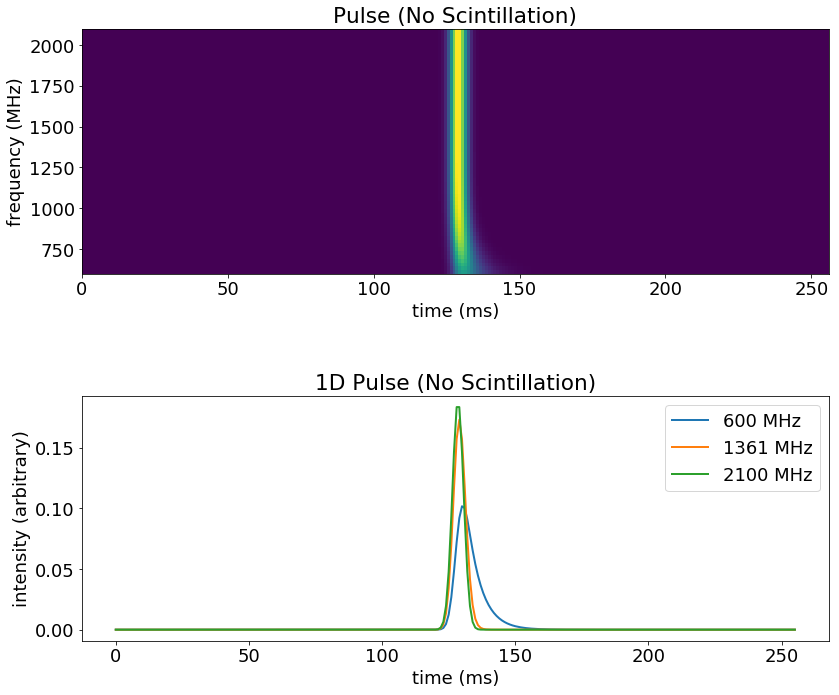

In [24]:
plot_simulation_steps('Pulse (No Scintillation)')

Note the exponential scattering features at the lowest frequencies. Due to energy conservation, each profile should bear the same amount of energy, even if lower frequncies are more scattered; thus, the area under each curve has been normalized to 1.

Finally, we pepper some scintillation into the pulse. Scintillation occurs in about 20% of the pulses, consistent with current FRB observations, and we show an example below.

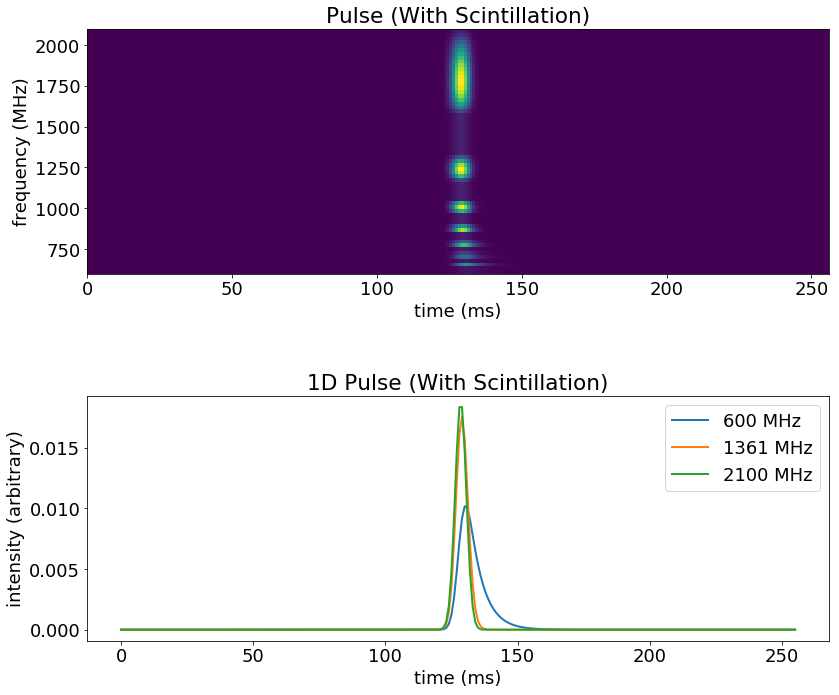

In [25]:
plot_simulation_steps('Pulse (With Scintillation)')

We proceed by selecting a random SNR to inject the FRBs with. The SNR is sampled from a log-normal distribution with unit mean and variance and summed with the minimum SNR value we choose. We also specify a maximum SNR, throw out the randomly selected SNR, and try again if it exceeds this value; doing so avoids pulses with abnormally high SNRs that are unhelpful in training.

After determining SNR, we also randomly choose the location of the pulse in the spectrogram and the fraction of the bandwidth that it will occupy. Both location and fractional bandwidth are sampled from uniform distributions.

Here comes the culmination of our simulation work: injecting the FRBs into backgrounds. Currently, the background arrays consist of Gaussian noise, but we plan on training the model on real RFI data. Below is a small menagerie of simulated FRBs.

/Users/dominicleduc/lib/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


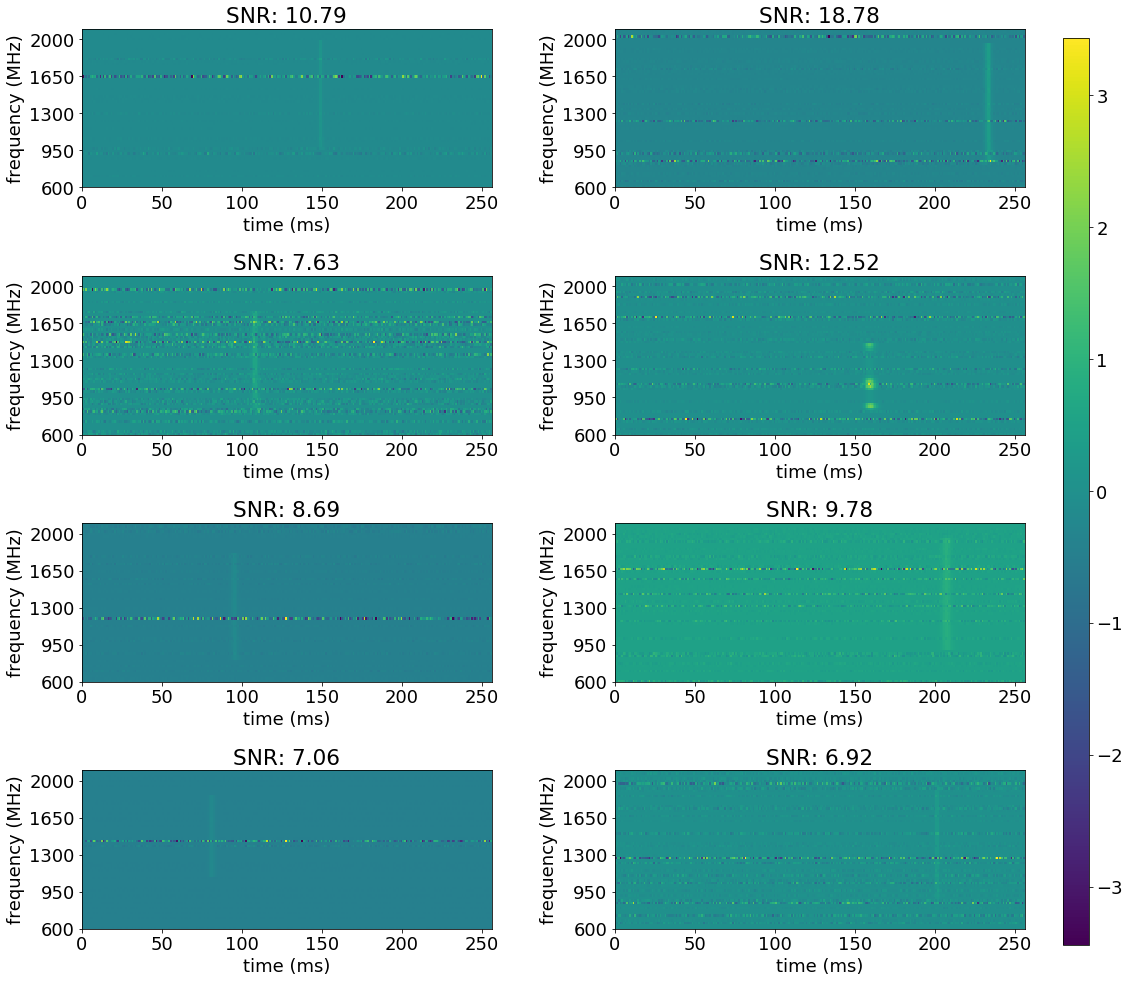

In [26]:
np.random.seed(63)

# create simulation objects and give an FRB to each of them
simulated_events = [SimulatedFRB() for i in np.arange(8)]
for event in simulated_events:
    event.simulateFRB(SNRmin=6, SNRmax=20)
    
# plot the simulated events
fig_simulated, ax_simulated = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))

for axis, event in zip(ax_simulated.flatten(), simulated_events):
    im = axis.imshow(event.simulatedFRB, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
                     origin='lower', aspect='auto')
    axis.set(title=f"SNR: {np.round(event.SNR, 2)}", xlabel='time (ms)', ylabel='frequency (MHz)')
    axis.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

# make a colorbar
cbar_ax = fig_simulated.add_axes([0.83, 0.05, 0.02, 0.9])
fig_simulated.colorbar(im, cax=cbar_ax)

fig_simulated.tight_layout()
fig_simulated.subplots_adjust(right=0.8, wspace=0.3)

## Defining the Convolutional Neural Network

Now comes the fun part: building the model! Inspired by Connor & van Leeuwen (2018), we construct a 2D convolutional neural network composed of two convolutional layers and two dense layers before ending with a binary softmax layer. The model is built using the popular neural network library Keras.

We optimize via stochastic gradient descent (SGD) with binary crossentropy as our loss. We save the model that performs most accurately on the cross-validation set during training.

In [130]:
def neural_network(train_data, train_labels, eval_data, eval_labels, 
                   nfreq=64, ntime=256, epochs=32, nfilt1=32, nfilt2=64,
                   n_dense1=128, n_dense2=64, batch_size=32, saved_model_name='classifier.h5'):
    """
    Trains a convolutional neural network to recognize differences between fast
    radio bursts and RFI. Training is done by simulating a specified number of FRB
    examples and injecting them into noisy backgrounds. Code adapted from Connor &
    van Leeuwen (2018)
    
    Parameters:
    ----------
    train_data : ndarray
        (nfreq, ntime, 1) array with frequency-time data
    train_labels :  ndarray
        (n_samples, 2) binary labels of training data [0, 1] = FRB, [1, 0]=RFI 
    eval_data : ndarray
        (nfreq, ntime, 1) array with evaluation data
    eval_labels : 
        (neval, 2) binary labels of eval data
    nfreq : int
        Number of frequency channels (y-axis)
    ntime : int
        Number of time bins (x-axis)
    epochs : int 
        Number of training epochs 
    nfilt1, nfilt2 : int
        Number of filters in first and second convolutional layers
    n_dense1, n_dense2 : int
        Number of neurons in first and second fully connected layers
    batch_size : int 
        Number of batches for training
    saved_model_name : str
        Filename to save the most accurate model on cross-validation set
       
    Returns
    -------
    model : Keras model
        Fitted model
    """
    # number of elements for each axis
    nfreq, ntime = train_data.shape[1:3]

    model = Sequential()

    # create nfilt1 convolution filters, each of size 3x3
    # max pool to reduce dimensionality
    model.add(Conv2D(nfilt1, (3, 3), activation='relu', input_shape=(nfreq, ntime, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second convolutional layer
    model.add(Conv2D(nfilt2, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # flatten all convolutional neurons
    model.add(Flatten())
    
    # run through fully connected layers 
    # randomly drop neurons to prevent overfitting
    model.add(Dense(n_dense1, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(n_dense2, activation='relu'))
    model.add(Dropout(0.3))

    # output probabilities of predictions and choose the maximum
    model.add(Dense(2, activation='softmax'))

    # optimize using stochastic gradient descent
    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Using batch_size: %d" % batch_size)
    print("Using %d epochs" % epochs)

    # save best model according to validation accuracy
    best_model_cb = keras.callbacks.ModelCheckpoint(saved_model_name, monitor='val_acc', verbose=1,
                                                    save_best_only=True)

    # fit the model
    model.fit(train_data, train_labels, validation_data=(eval_data, eval_labels),
              batch_size=batch_size, epochs=epochs, callbacks=[best_model_cb])

    # score model one last time at the end of training
    score = model.evaluate(eval_data, eval_labels, batch_size=batch_size)
    print(score)

    return model

We visualize the model architecture with Haris Iqbal's [PlotNeuralNet](https://github.com/HarisIqbal88/PlotNeuralNet) tool. Josh Bloom, this one's for you.

<center>
<img src=presentation_plots/visualize_neural_network.png>
</center>

**NOTE: Heights of the convolutional layers are not to scale, and Dropout/Flatten layers are not shown.**

The neural network takes in an input image of shape (64, 256). Following that, orange rectangles represent convolutional layers and max pooling, and light purple blocks denote fully connected layers.

## Building the Training Set

Of course, now that we've defined the model, we need to construct a training set of labeled data. To do so, we create 5,000 simulation objects using the SimulateFRB class. 

For each object, we take the background array and label it 0 to mean RFI. We then inject an FRB into the background and label the resulting array with 1, corresponding to an FRB.

In total, we end up with a training set of 10,000 samples with perfectly balanced classes. Be prepared to have your memory eaten by the size of this thing; the saved data is a ridiculous 1.31 GB large.

In [ ]:
def normalize_data(ftdata):
    """Pretty straightforward, normalizes the data
    to zero median, unit variance"""
    dshape = ftdata.shape

    ftdata = ftdata.reshape(len(ftdata), -1)
    ftdata -= np.median(ftdata, axis=-1)[:, None]
    ftdata /= np.std(ftdata, axis=-1)[:, None]

    # zero out nans
    ftdata[ftdata != ftdata] = 0.0
    ftdata = ftdata.reshape(dshape)
    
    return ftdata

In [62]:
def make_labels(num_samples, SNRmin=5, SNRmax=15, FRB_parameters={'f_low': 800, 
                'f_high': 2000, 'f_ref': 1350, 'bandwidth': 1500}, background_file=None):

    '''Simulates the background for num_data number of points and appends to ftdata.
    Each iteration will have just noise and an injected FRB, so the label list should
    be populated with just 0 and 1, which will then be shuffled later.'''

    ftdata = []
    labels = []
    
    if background_file is not None:
        # load in background file and extract data and frequencies
        background_npz = np.load(background_file)
        backgrounds = background_npz['rfi_data']
        freq_RFI = background_npz['freq']

        # change frequency range of simulated pulse based on incoming RFI files
        FRB_parameters['f_ref'] = np.median(freq_RFI)
        FRB_parameters['bandwidth'] = np.ptp(freq_RFI)

    for sim in trange(num_samples):
        # create simulation object and add FRB to it
        event = SimulatedFRB(**FRB_parameters)
        
        if background_file is None:
            event.simulateFRB(background=None, SNRmin=SNRmin, SNR_sigma=1.0, SNRmax=SNRmax)
        else:
            # select a random background from the given arrays
            random_index = np.random.choice(backgrounds.shape[0])
            background_RFI = backgrounds[random_index]
            
            # inject FRB into real noise array and append label the noise as RFI
            event.simulateFRB(background=background_RFI, SNRmin=SNRmin, SNR_sigma=1.0, SNRmax=SNRmax)
        
        # append noise to ftdata and label it RFI
        ftdata.append(event.background)
        labels.append(0)

        # inject FRB into data and label it true sighting
        ftdata.append(event.simulatedFRB)
        labels.append(1)

    ftdata, labels = np.array(ftdata), np.array(labels)

    return normalize_data(ftdata), labels

In [49]:
# create 10000 training examples with SNR range of [5, 15]
ftdata, labels = make_labels(5000, SNRmin=5, SNRmax=15)

100%|██████████| 5000/5000 [00:18<00:00, 270.14it/s]


For preprocessing, we normalize the data to zero median and unit variance *per row* by subtracting the median and dividing out the standard deviation of each row. This standardizes the arrays but still allows the FRBs to pop out.

In [50]:
# have to reshape due to NumPy quirks in array operations
ftdata_shape = ftdata.shape

# normalize data
ftdata = ftdata.reshape(len(ftdata), -1)
ftdata -= np.median(ftdata, axis=-1)[:, None]
ftdata /= np.std(ftdata, axis=-1)[:, None]

# zero out nans
ftdata[ftdata != ftdata] = 0.0
ftdata = ftdata.reshape(ftdata_shape)

We shuffle the training data to introduce randomness and perform an 80-20 split to separate the simulated data into training and validation sets. A few training examples are plotted below.

In [123]:
# give ftdata a 4th dimension for Keras. RUN ONCE ONLY!
ftdata_4D = ftdata[..., None]

# train on 80% of the data, validate on remaining 20%
NTRAIN = int(len(labels) * 0.8)

num_samples, nfreq, ntime = ftdata.shape
ind = np.arange(num_samples)

# shuffle the indices
np.random.shuffle(ind)

# split indices into training and evaluation set
ind_train = ind[:NTRAIN]
ind_eval = ind[NTRAIN:]

train_data, eval_data = ftdata_4D[ind_train], ftdata_4D[ind_eval]
train_labels, eval_labels = labels[ind_train], labels[ind_eval]

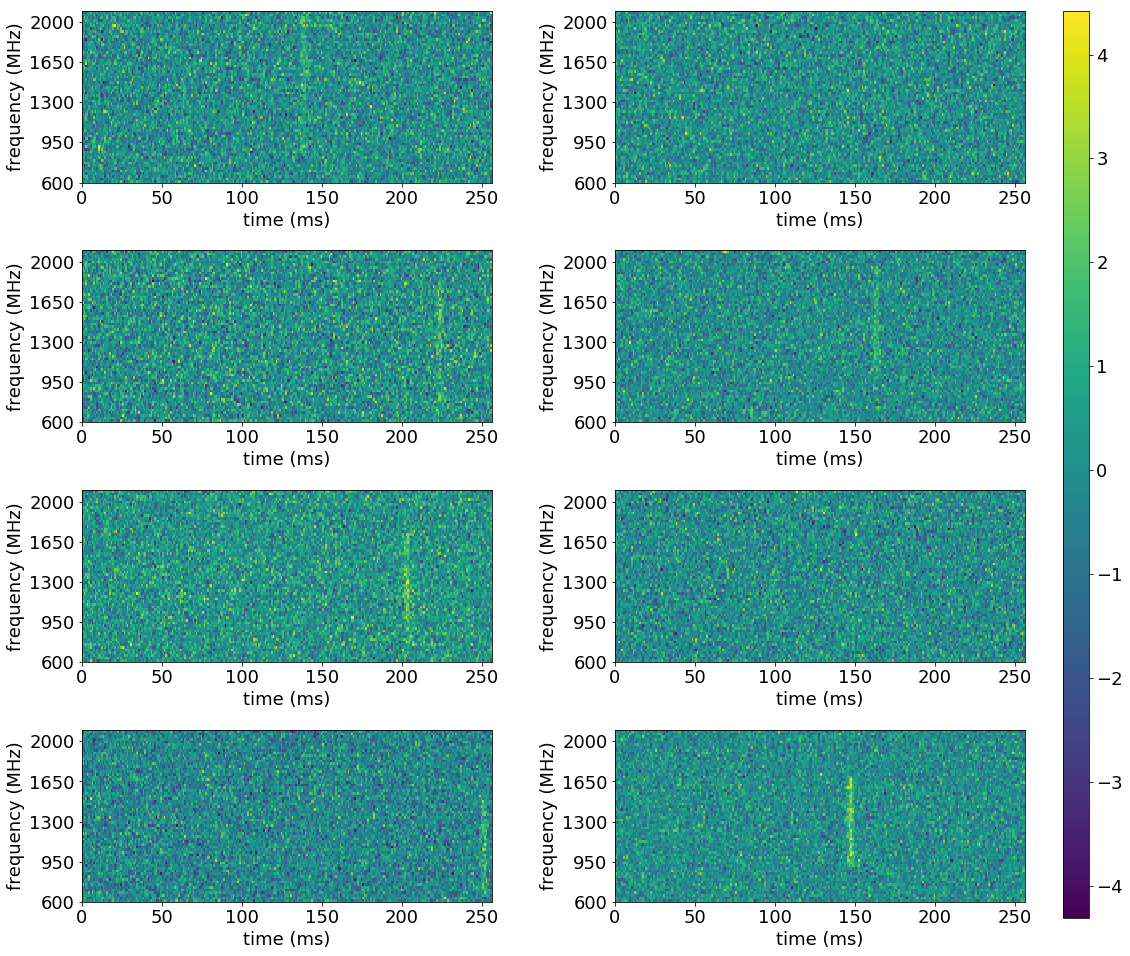

In [127]:
np.random.seed(256)

# plot a random chunk of training data
fig_train, ax_train = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))

for axis, data_array in zip(ax_train.flatten(), train_data[np.random.randint(0, 8000, size=8)]):
    im = axis.imshow(data_array[:, :, 0], extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
                     origin='lower', aspect='auto')
    axis.set(xlabel='time (ms)', ylabel='frequency (MHz)')
    axis.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

# make a colorbar
cbar_ax = fig_train.add_axes([0.83, 0.05, 0.02, 0.9])
fig_train.colorbar(im, cax=cbar_ax)

fig_train.tight_layout()
fig_train.subplots_adjust(top=0.95, right=0.8, wspace=0.3)

The examples show arrays with pure noise and arrays with FRBs in them, so both classes are included in the training set. The noise and FRBs are also not repeated in a pattern, indicating that the data have been properly shuffled.

## Train, train, train

Now that the training set has been assembled and preprocessed, we can finally teach the neural network how to recognize FRBs!

Training will be done in 32 epochs with a batch size of 32. This will run exceptionally slowly on any machine that doesn't utilize the amazing power of GPUs. The training code is still written out below in case you want to try it out, though we will just reload our previously saved model for convenience.

In [131]:
# convert to binary matrix, again for Keras
train_labels_keras = keras.utils.to_categorical(train_labels)
eval_labels_keras = keras.utils.to_categorical(eval_labels)

# may need to set this to save the model
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [ ]:
# Fit convolution neural network to the training data
model = neural_network(train_data=train_data, train_labels=train_labels_keras,
                       eval_data=eval_data, eval_labels=eval_labels_keras)

In [183]:
num_conv_layers = 4
filter_size = 32

model = Sequential()

# create filter_size convolution filters, each of size 2x2
# max pool to reduce the dimensionality
model.add(Conv2D(filter_size, (2, 2), activation='relu', input_shape=(64, 256, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# repeat and double the filter size for each convolutional block to make this DEEP
for i in np.arange(num_conv_layers - 1):
    filter_size *= 2

    model.add(Conv2D(filter_size, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

# flatten all neurons
model.add(Flatten())

# run through two fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# output prediction probabilities and choose the class with higher probability
model.add(Dense(2, activation='softmax'))

# optimize using Adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_368 (Conv2D)          (None, 63, 255, 32)       160       
_________________________________________________________________
max_pooling2d_236 (MaxPoolin (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_369 (Conv2D)          (None, 30, 126, 64)       8256      
_________________________________________________________________
max_pooling2d_237 (MaxPoolin (None, 15, 63, 64)        0         
_________________________________________________________________
conv2d_370 (Conv2D)          (None, 14, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_238 (MaxPoolin (None, 7, 31, 128)        0         
_________________________________________________________________
conv2d_371 (Conv2D)          (None, 6, 30, 256)        131328    
__________

In [121]:
model = Sequential()

# create nfilt1 convolution filters, each of size 5x5
# max pool and randomly drop some fraction of nodes to limit overfitting
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(64, 256, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# second convolutional layer with 64 filters
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# flatten all neurons
model.add(Flatten())

# run through fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# output probabilities of predictions and choose the maximum
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 63, 255, 32)       160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 127, 32)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 126, 64)       8256      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 63, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 15, 63, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 60480)             0         
__________

## Loading in Saved Model
We load in a saved model because training takes too long on local machine with only CPU.

In [184]:
# reload model because training takes so long
# real_model = load_model('FRB_model.h5')
model = load_model('deep_maximized_recall.h5')
# optimize with adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/dominicleduc/lib/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


As proof that the model is exactly how we specified, the summary is printed out below.

In [185]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 63, 255, 32)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 127, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 126, 64)       8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 63, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 31, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 30, 256)        131328    
__________

## Performance Metrics: Confusion Matrix

We now test the ability of our model to generalize on unseen data. Firstly, we create a completely independent test set filled with 10,000 samples and predict on those samples. Subsequently, we'll look at the confusion matrix, which is a metric that displays the number of true positives, false positives, true negatives, and false negatives predicted by the model.

In [186]:
def get_classification_results(y_true, y_pred):
    """ Take true labels (y_true) and model-predicted 
    label (y_pred) for a binary classifier, and return indices of
    true_positives, false_positives, true_negatives, and false_negatives
    """
    TP = np.where((y_true == 1) & (y_pred == 1))[0]
    FP = np.where((y_true == 0) & (y_pred == 1))[0]
    TN = np.where((y_true == 0) & (y_pred == 0))[0]
    FN = np.where((y_true == 1) & (y_pred == 0))[0]
    
    return TP, FP, TN, FN

def confusion_mat(y_true, y_pred):
    """ Generate a confusion matrix for a
    binary classifier based on true labels (
    y_true) and model-predicted label (y_pred)

    returns np.array([[TP, FP],[FN, TN]])
    """
    TP, FP, TN, FN = get_classification_results(y_true, y_pred)

    NTP = len(TP)
    NFP = len(FP)
    NTN = len(TN)
    NFN = len(FN)

    conf_mat = np.array([[NTP, NFP], [NFN, NTN]])
    return conf_mat

The below function, `confusion_matrix_per_SNR`, will be especially useful in diagnosing model performance, since it takes in the model, a number of samples to generate the test set, and a range of SNRs that will reflect the test set and returns the test set and the confusion matrix from the model's prediction results.

In [187]:
def confusion_matrix_per_SNR(model, num_samples, SNR_range, background_file=None, 
                             frb_parameters={'f_low': 800, 'f_high': 2000, 
                                             'f_ref': 1350, 'bandwidth': 1500}):
    """Predict a model based on a given range of SNRs and
    return metrics summarizing the model performance.
    
    Parameters:
    ----------
    model : Keras model
        Model to predict with. Must be compiled!
    num_samples : int
        Number of freq-time arrays to generate and predict
    SNR_range : ndarray 
        (2,) Array of two elements consisting of SNRmin and SNRmax
        for the range of the SNRs to be predicted
    
    Returns
    -------
    test_set : ndarray
        (num_samples * 2, 64, 256) Test set that model predicts on
    confusion_mat : ndarray
        (2, 2) confusion matrix [[TP, FP], [FN, TN]]
    """
    SNRmin, SNRmax = SNR_range
    test_set, test_labels = make_labels(num_samples, SNRmin=SNRmin, SNRmax=SNRmax, 
                                        FRB_parameters=frb_parameters, background_file=background_file)
    
    # make predictions with the model
    start = time()
    pred_probabilities = model.predict(test_set[..., None])[:, 1]
    predictions = np.round(pred_probabilities)
    print(f"Predicting {num_samples} samples took {time() - start} seconds")
    
    return test_set, test_labels, confusion_mat(test_labels, predictions), pred_probabilities

In [188]:
np.random.seed(128)

# create a test set and the confusion matrix from predicting on that test set
frb_parameters = {'f_low': 1850, 'f_high': 2700, 'f_ref': 2500, 'bandwidth': 1000}
test_set, test_labels, confusion_matrix, pred_probabilities = confusion_matrix_per_SNR(model, 5000, SNR_range=[8, 16],
                                                                                      frb_parameters=frb_parameters,
                                                                                      background_file='dedispered_with_freqtime.npz')

100%|██████████| 5000/5000 [00:18<00:00, 275.34it/s]


Predicting 5000 samples took 34.20412230491638 seconds


In [189]:
NTP, NFP, NTN, NFN = confusion_matrix[0, 0], confusion_matrix[0, 1], confusion_matrix[1, 1], confusion_matrix[1, 0]

print("Confusion matrix:")
print(confusion_matrix)

accuracy = (NTP + NTN) / confusion_matrix.sum()
precision = NTP / (NTP + NFP)
recall = NTP / (NTP + NFN)
fscore = 2 * precision * recall / (precision + recall)

print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"fscore: {fscore}")

Confusion matrix:
[[5000   42]
 [   0 4958]]
accuracy: 0.9958
precision: 0.9916699722332408
recall: 1.0
fscore: 0.9958175662218681


Based on these metrics, the model performs quite well, able to predict with over 98% success in each category. The number of false positives and false negatives is about the same, likely triggered by low SNR arrays.

We have not gone in-depth on the exact of these accuracy, precision, recall, and fscore. Each of these quantities is important in assessing the quality of the model, but the two we will focus discussion on are recall and accuracy.

/Users/dominicleduc/lib/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


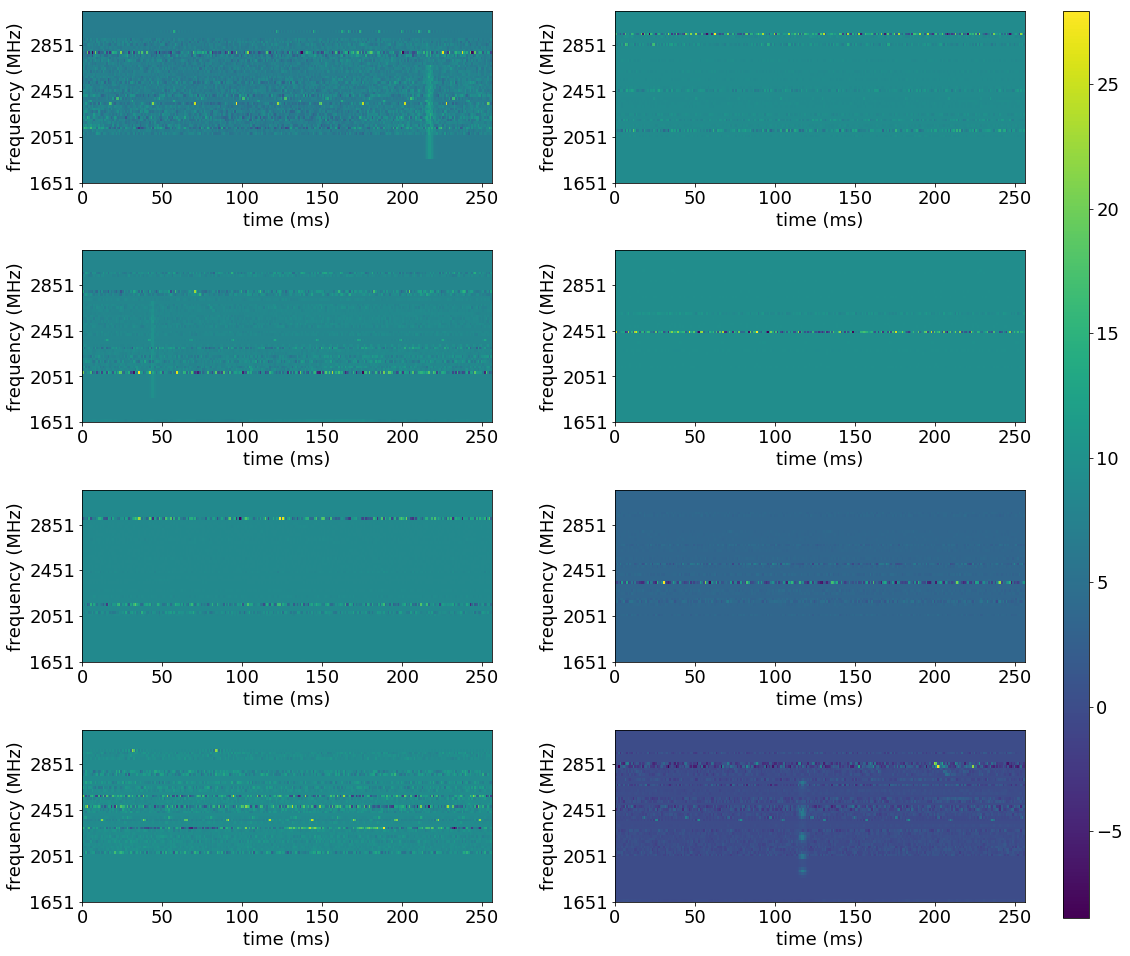

In [190]:
# check out what's up with the test set
event = SimulatedFRB(**frb_parameters)

fig_validation, ax_validation = plt.subplots(nrows=4, ncols=2, figsize=(18, 14))

# plot a random chunk of test data
for ax, image in zip(ax_validation.flatten(), test_set[np.random.randint(0, len(test_set), size=8)]):
    im = ax.imshow(image, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
                     origin='lower', aspect='auto')
    ax.set(xlabel='time (ms)', ylabel='frequency (MHz)')
    ax.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 400))

# make a colorbar
cbar_ax = fig_validation.add_axes([0.83, 0.05, 0.02, 0.9])
fig_validation.colorbar(im, cax=cbar_ax)

fig_validation.tight_layout()
fig_validation.subplots_adjust(top=0.95, right=0.8, wspace=0.3)

## Performance Metrics: Recall

While most people judge the "goodness" of a model based on its accuracy, we decided to prioritize recall, given by

\begin{align}
recall = \frac{true\ positives}{true\ positives + false\ negatives}
\end{align}

In words, recall is the ability of the model to find FRBs in the data, the proportion of FRBs in the test set that it was able to detect. Because the goal is to find as many FRBs as possible, recall is the quantity of interest. 

We now plot the model's recall as function of SNR. We do this by simulating 1000 examples per SNR bin (bin width  = 1 SNR) and predicting on those 1000 examples before moving on to the next bin. The next plot contains the percentage of missed FRBs and the recall at each SNR bin.

In [191]:
np.random.seed(128)

SNR_range = np.array([0, 1])
num_incorrect, num_missed_FRBs = [], []
accuracies, recalls = [], []

while SNR_range[1] <= 15:
    conf_mat = confusion_matrix_per_SNR(model, 1000, SNR_range=SNR_range, frb_parameters=frb_parameters,
                                        background_file='dedispered_with_freqtime.npz')[2]
    NTP, NFP, NTN, NFN = conf_mat[0, 0], conf_mat[0, 1], conf_mat[1, 1], conf_mat[1, 0]
        
    accuracy = (NTP + NTN) / conf_mat.sum()
    recall = NTP / (NTP + NFN)
    
    # append number of incorrect results for each SNR bin
    num_incorrect.append(NFP + NFN)
    num_missed_FRBs.append(NFN)
    
    # append metrics to list for each SNR bin
    accuracies.append(accuracy)
    recalls.append(recall)
    
    SNR_range += 1

  3%|▎         | 29/1000 [00:00<00:03, 288.27it/s]

Predicting 1000 samples took 6.386499881744385 seconds


  3%|▎         | 32/1000 [00:00<00:03, 312.64it/s]

Predicting 1000 samples took 6.2282679080963135 seconds


  3%|▎         | 30/1000 [00:00<00:03, 297.49it/s]

Predicting 1000 samples took 6.191885948181152 seconds


  3%|▎         | 32/1000 [00:00<00:03, 311.19it/s]

Predicting 1000 samples took 6.216604232788086 seconds


  3%|▎         | 32/1000 [00:00<00:03, 314.96it/s]

Predicting 1000 samples took 6.22282600402832 seconds


  3%|▎         | 32/1000 [00:00<00:03, 319.50it/s]

Predicting 1000 samples took 6.208078861236572 seconds


  3%|▎         | 28/1000 [00:00<00:03, 274.66it/s]

Predicting 1000 samples took 6.224797964096069 seconds


  3%|▎         | 31/1000 [00:00<00:03, 309.51it/s]

Predicting 1000 samples took 6.263463973999023 seconds


  3%|▎         | 31/1000 [00:00<00:03, 304.71it/s]

Predicting 1000 samples took 6.274783134460449 seconds


  3%|▎         | 32/1000 [00:00<00:03, 315.65it/s]

Predicting 1000 samples took 6.177206039428711 seconds


  3%|▎         | 33/1000 [00:00<00:02, 325.84it/s]

Predicting 1000 samples took 6.240907907485962 seconds


  3%|▎         | 32/1000 [00:00<00:03, 317.96it/s]

Predicting 1000 samples took 6.244021892547607 seconds


  3%|▎         | 32/1000 [00:00<00:03, 312.11it/s]

Predicting 1000 samples took 6.233922243118286 seconds


  3%|▎         | 32/1000 [00:00<00:03, 315.68it/s]

Predicting 1000 samples took 6.26952600479126 seconds


100%|██████████| 1000/1000 [00:02<00:00, 351.22it/s]


Predicting 1000 samples took 6.255275011062622 seconds


In [192]:
# ColumnDataSource object for Bokeh
metricsCDS = ColumnDataSource(data={'x': np.arange(1, 16), 'recalls': recalls, 'accuracies': accuracies,
                                    'percent_missed_FRBs': np.array(num_missed_FRBs) / 1000,
                                    'percent_incorrect': np.array(num_incorrect) / 2000})

In [193]:
# plot recall
recall_plot = figure(title='Neural Network Recall', x_axis_label='SNR', y_axis_label='percentage (%)',
                      y_range=(-0.01, 1.01), width=800)
recall_plot.vbar(x='x', top='percent_missed_FRBs', source=metricsCDS, 
                 width=0.8, alpha=0.85, legend='Missed FRBs')
recall_plot.line('x', 'recalls', source=metricsCDS, line_width=2, color=colors['orange'], 
                 line_alpha=0.8, legend='Recall Rate')
recall_plot.legend.location = "top_right"

# change font sizes
recall_plot.title.text_font_size = '16pt'
recall_plot.xaxis.axis_label_text_font_size = "14pt"
recall_plot.yaxis.axis_label_text_font_size = "14pt"
recall_plot.legend.label_text_font_size = "12pt"

recall_plot.add_tools(HoverTool(tooltips=[("SNR", "@x"), ("recall", "@recalls{1.222}"), 
                                          ("missed", "@percent_missed_FRBs{1.121}")]))
show(recall_plot)

Hover over the bars or lines to see the actual numbers for each bin!

## Performance Metrics: Accuracy

Of course, since recall is just the number of FRBs that model classifies correctly as FRBs, it can be maximized solely by classifying every single object as an FRB. We avoid this by showcasing our model's accuracy as well, which is simply defined as the proportion of correct classifications.

\begin{align}
accuracy = \frac{true\ positives + true\ negatives}{number\ of\ samples}
\end{align}

In [194]:
# plot accuracy
accuracy_plot = figure(title='Neural Network Accuracy', x_axis_label='SNR', y_axis_label='percentage (%)',
                      y_range=(-0.01, 1.01), width=800)
accuracy_plot.vbar(x='x', top='percent_incorrect', source=metricsCDS, 
                 width=0.8, alpha=0.85, legend='Incorrect Predictions')
accuracy_plot.line('x', 'accuracies', source=metricsCDS, line_width=2, color=colors['orange'], 
                 line_alpha=0.8, legend='Accuracy Rate')
accuracy_plot.legend.location = "top_right"

# change font sizes
accuracy_plot.title.text_font_size = '16pt'
accuracy_plot.xaxis.axis_label_text_font_size = "14pt"
accuracy_plot.yaxis.axis_label_text_font_size = "14pt"
accuracy_plot.legend.label_text_font_size = "12pt"

accuracy_plot.add_tools(HoverTool(tooltips=[("SNR", "@x"), ("accuracy", "@accuracies{1.222}"), 
                                          ("incorrect", "@percent_incorrect{1.121}")]))
show(accuracy_plot)

As expected, accuracy drops to 50% at low SNRs, which means the neural network is randomly guessing between FRB and RFI. This makes sense, as an object at such low SNR would probably go undetected by humans as well—in fact, it becomes hard to manually pick out pulses at SNRs of about 4.

Given the simplicity of the model and size of the training set, the performance is outstanding. We hope that increasing model complexity and number of training samples will improve performance even further, but this would mean sacrificing speed.

## Lowest Probability Predictions

We also show the predictions the neural network made that the model had the least confidence in.

In [195]:
TP, FP, TN, FN = get_classification_results(test_labels, np.round(pred_probabilities))

# pick out the array with the minimum probability prediction for each box in confusion matrix
lowest_prob = lambda x: test_set[x[np.argmin(pred_probabilities[x])]]
least_probable = np.array([lowest_prob(x) if x.size > 0 else np.zeros(shape=(64, 256)) for x in [TP, FP, FN, TN]])

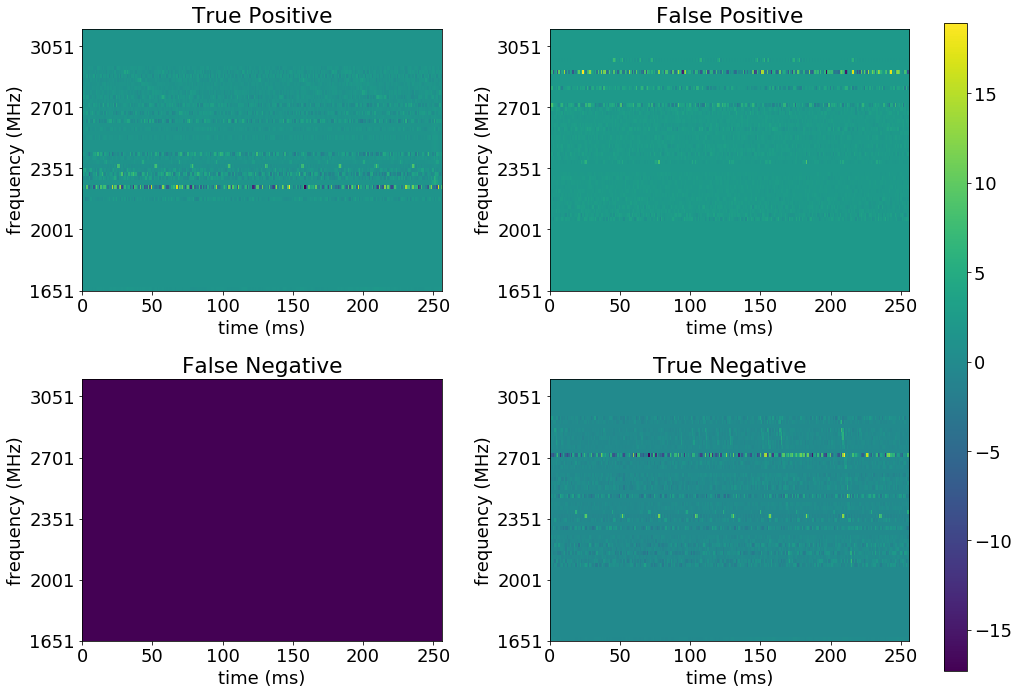

In [196]:
fig_confusion, ax_confusion = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
confmat_titles = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

for image, ax, title in zip(least_probable, ax_confusion.flatten(), confmat_titles):
    im = ax.imshow(image, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
              origin='lower', aspect='auto')
    ax.set(title=title, xlabel='time (ms)', ylabel='frequency (MHz)')
    ax.set_yticks(np.arange(event.frequencies[0], event.frequencies[-1], 350))

# make a colorbar
cbar_ax = fig_confusion.add_axes([0.83, 0.05, 0.02, 0.9])
fig_confusion.colorbar(im, cax=cbar_ax)

fig_confusion.tight_layout()
fig_confusion.subplots_adjust(right=0.8, wspace=0.3)

While the false positive and true negative plots are not interesting (they don't have any signal), the true positve/false negative plots are notable. Specifically, the pulses in both are barely noticeable, which makes sense, since these are predictions the model is least confident in. 

The lowest probability True Positive lies in the middle of the image (at least for a random seed of 128). The False Negative pulse in particular is nearly indistinguishable from the noise, but you can convince yourself that it is a little to the left of the 100 ms mark.

Overall, this means the network is capable of classifying low SNR FRBs in noisy backgrounds that would often elude human detection.

## Moving onto Real RFI

The next step in this project would involve injecting FRBs into real noisy data. A fundamental source of error that could arise in training our model is that **Gaussian noise is too simple to model actual noise**. That is, true RFI does not look Gaussian and is too unpredictable to be adequately modeled, so it would be best to train the model on backgrounds with actual RFI in them.

A few instances of real RFI are shown below, taken from observations at the Green Bank Telescope (GBT) in West Virginia.

Future work would see the exact same FRB simulation process; the only exception would be to inject FRBs into real noise rather than the original Gaussian backgrounds.

The neural network will likely have trouble with backgrounds that look like the one in the top right, since it looks just like an FRB. The hope is for the automatic featurization in the convolutional layers to be able to distinguish between the two classes. Of course, will adjust the number of filters, neurons, and layers if necessary.

For now, the results of this analysis are very encouraging and showcases the power of deep learning on FRB detection.

RFI shape: (588, 64, 256)


/Users/dominicleduc/lib/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


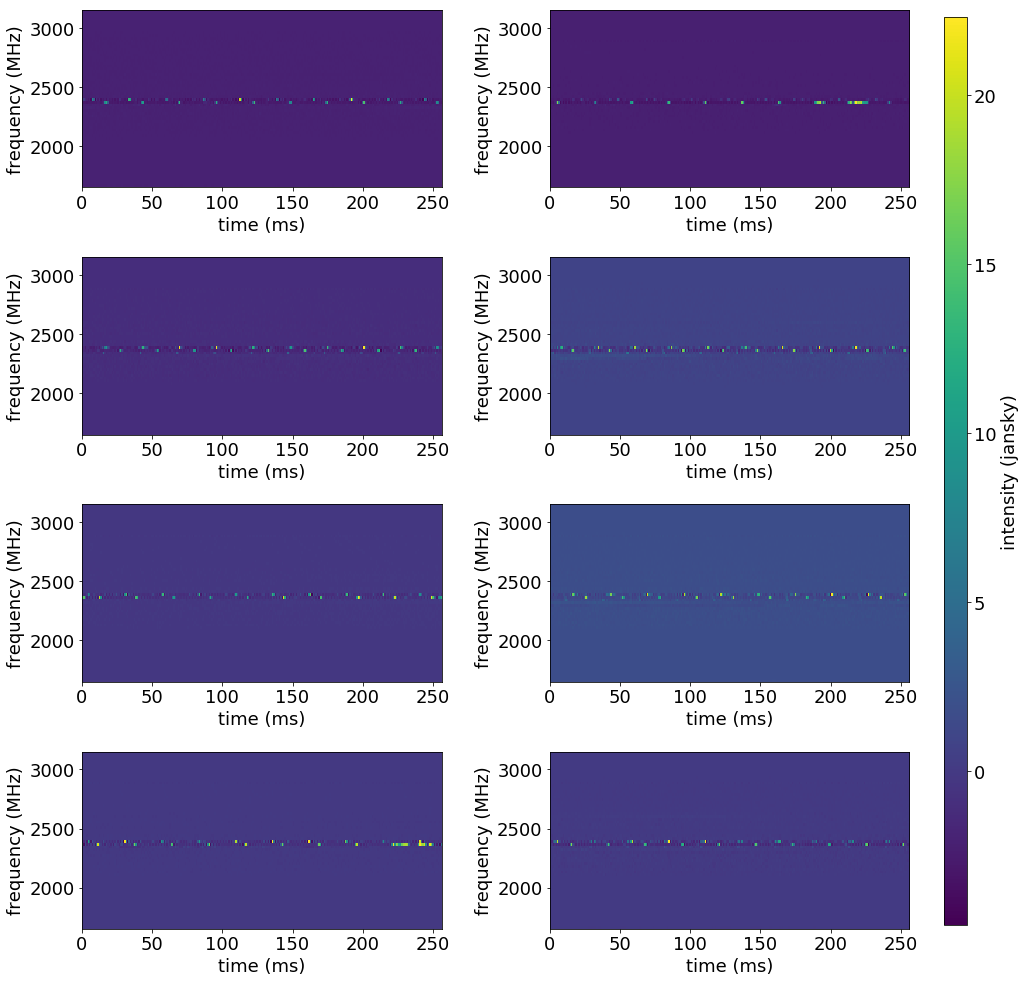

In [39]:
"""RFI with random DM from 0 to 1000"""
np.random.seed(120)
RFI_array = np.load('dedispered_with_freqtime.npz')
real_RFI = RFI_array['rfi_data']
print(f"RFI shape: {real_RFI.shape}")

event = SimulatedFRB(f_ref=np.median(RFI_array['freq']), bandwidth=np.ptp(RFI_array['freq']), 
                    f_low=1850, f_high=2700)

# plot RFI
sample_RFI = real_RFI[np.random.randint(low=0, high=320, size=8)]

fig_RFI, ax_RFI = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))

for RFI_image, ax in zip(sample_RFI, ax_RFI.flatten()):
    im = ax.imshow(RFI_image, extent=[0, event.nt, event.frequencies[0], event.frequencies[-1]],
              origin='lower', aspect='auto')
    ax.set(xlabel='time (ms)', ylabel='frequency (MHz)')

# make a colorbar (now with actual units!)
cbar_ax = fig_RFI.add_axes([0.83, 0.07, 0.02, 0.9])
fig_RFI.colorbar(im, cax=cbar_ax, label='intensity (jansky)')

fig_RFI.tight_layout()
fig_RFI.subplots_adjust(right=0.8, wspace=0.3)

In [40]:
# normalize the RFI so each sum is row sums up to 1
normed_RFI = np.divide(sample_RFI, np.trapz(sample_RFI, axis=2)[:, :, None], out=np.zeros_like(sample_RFI), 
                       where = np.trapz(sample_RFI, axis=2)[:, :, None] > 0)

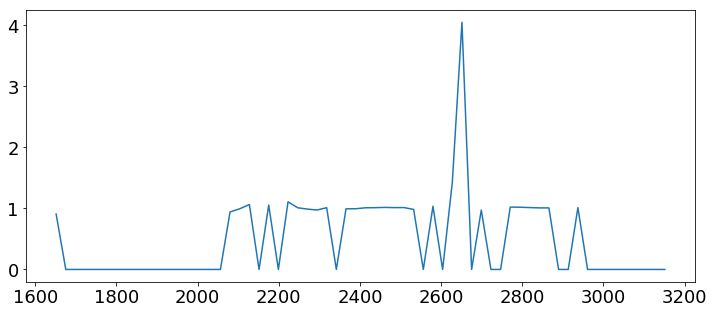

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(event.frequencies, np.sum(normed_RFI[0], axis=1))

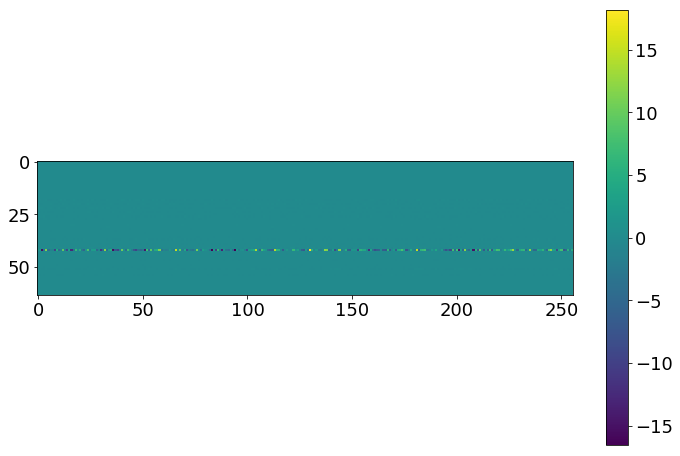

In [42]:
plt.figure(figsize=(12, 8))
plt.imshow(normed_RFI[0])
plt.colorbar()

In [59]:
np.random.seed(30)
event = SimulatedFRB(**frb_parameters)

event.scintillate()
injected_FRB = event.injectFRB(SNR=10)
event.roll()

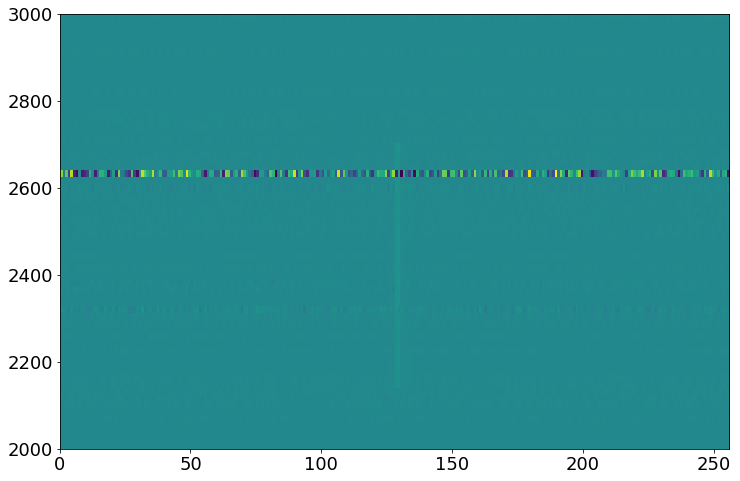

In [60]:
plt.figure(figsize=(12, 8))
plt.imshow(injected_FRB, origin='lower', extent=[0, 256, 2000, 3000], aspect='auto')

In [61]:
# ensure frb_parameters are what they should be
frb_parameters

{'f_low': 1850, 'f_high': 2700, 'f_ref': 2401.46484375, 'bandwidth': 1500.0}

In [76]:
# make a set of data and labels for of tiny SNR—how does the neural network get these?!
lowSNR_ftdata, lowSNR_labels = make_labels(num_samples=10, SNRmin=1, SNRmax=2, FRB_parameters=frb_parameters,
                                          background_file='dedispered_with_freqtime.npz')


100%|██████████| 10/10 [00:00<00:00, 278.51it/s]

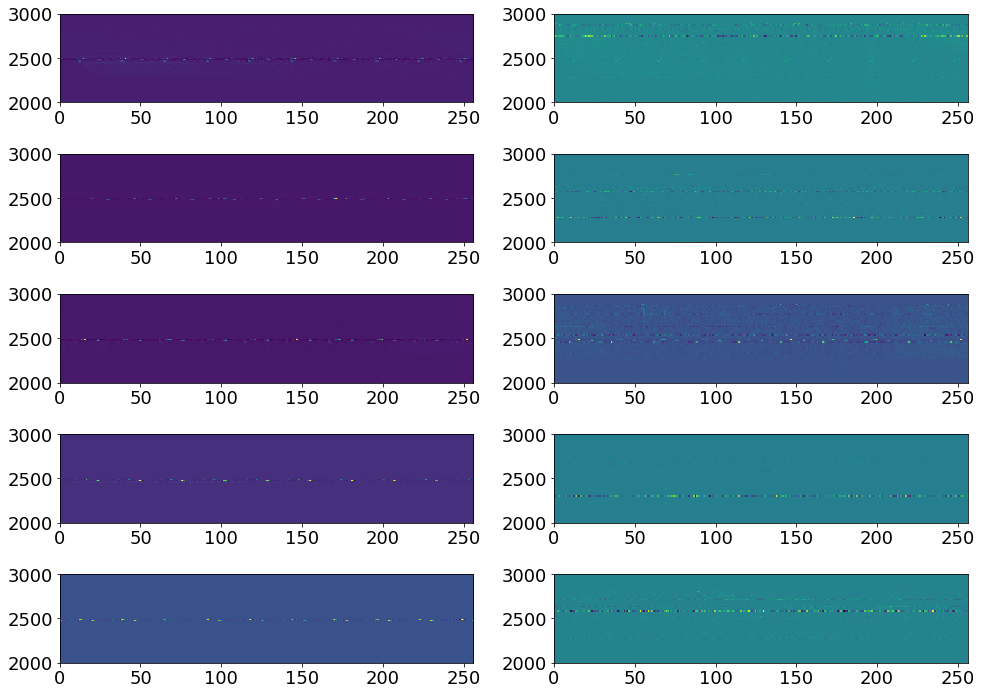

In [77]:
"""You literally can't see anything on the right side, since there's a SUPER LOW FRB signal there."""

# plot samples in order from the low SNR test data
fig_lowSNR, ax_lowSNR = plt.subplots(nrows=5, ncols=2, figsize=(14, 10))
for ftdata, ax in zip(lowSNR_ftdata[:10], ax_lowSNR.flatten()):
    ax.imshow(ftdata, origin='lower', extent=[0, 256, 2000, 3000], aspect='auto')
    
fig_lowSNR.tight_layout()

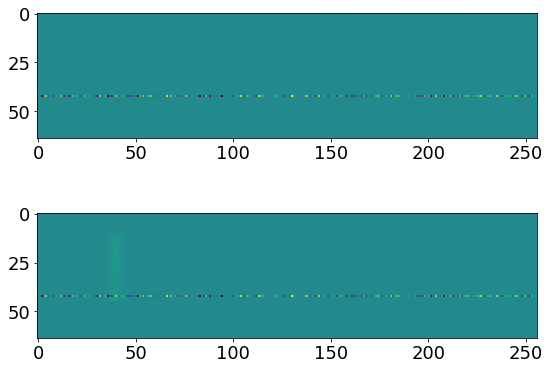

In [90]:
normalization_event = SimulatedFRB(**frb_parameters)
normalization_event.simulateFRB(background=sample_RFI[0], SNRmin=10, SNRmax=20)

plt.figure(figsize=(8, 6))

# plain RFI plot
plt.subplot(211)
plt.imshow(normalization_event.background)

plt.subplot(212)
plt.imshow(normalization_event.simulatedFRB)

plt.tight_layout()


100%|██████████| 1/1 [00:00<00:00, 169.12it/s]

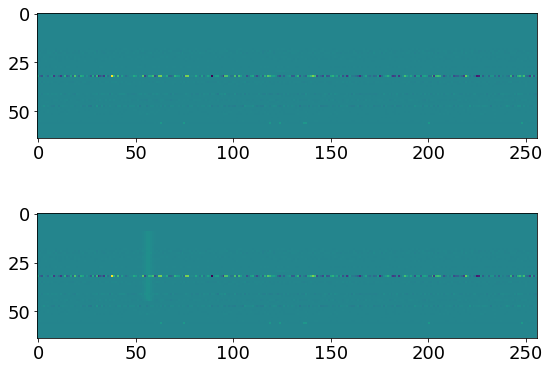

In [93]:
test_normalization_data, test_normalization_labels =  make_labels(1, SNRmin=10, SNRmax=20, 
                                                                  FRB_parameters=frb_parameters, 
                                                                  background_file='dedispered_with_freqtime.npz')
plt.figure(figsize=(8, 6))

# plain RFI plot
plt.subplot(211)
plt.imshow(test_normalization_data[0])

plt.subplot(212)
plt.imshow(test_normalization_data[1])

plt.tight_layout()

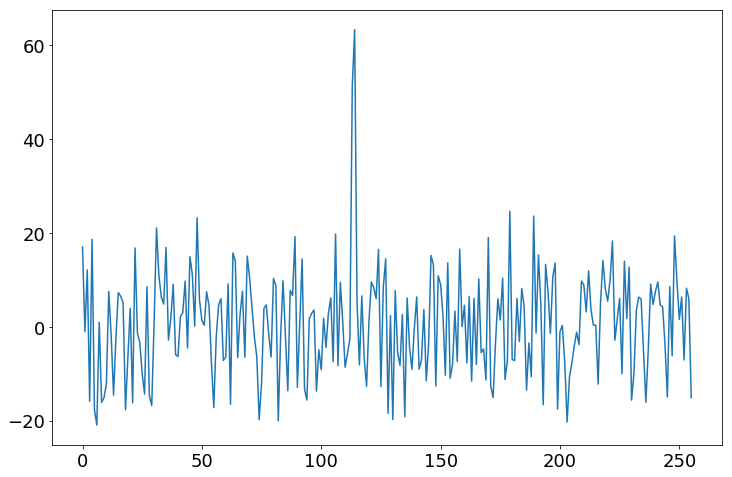

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(np.sum(event.injectFRB(SNR=10), axis=0))

In [79]:
signal = event.injectFRB(SNR=6)

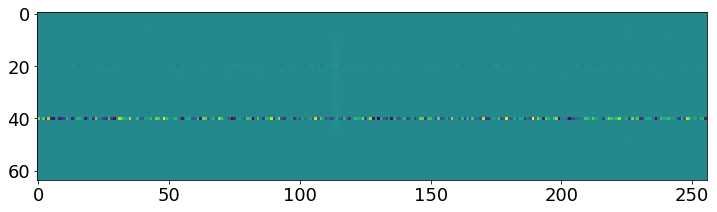

In [80]:
plt.figure(figsize=(12, 8))
plt.imshow(signal)

In [81]:
RFI_array = np.load('dedispered_with_freqtime.npz')

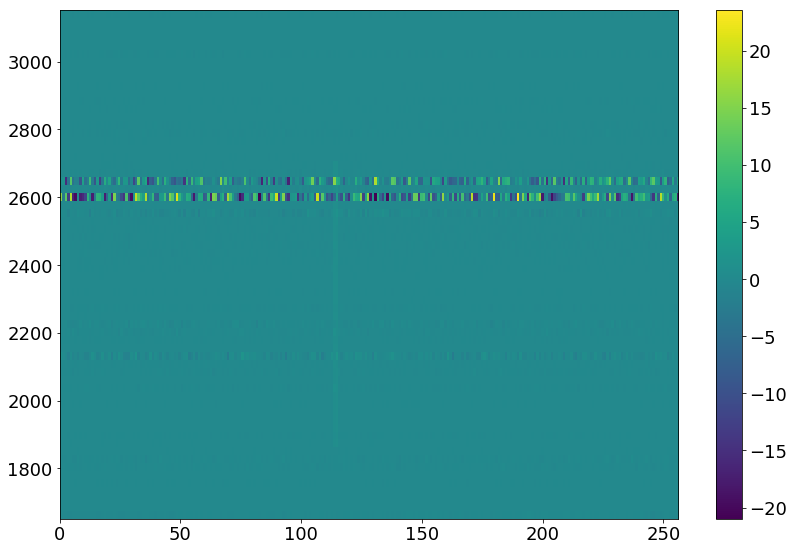

In [82]:
plt.figure(figsize=(12, 8))
plt.imshow(normed_RFI[0] + signal, origin='lower', extent=[0, 256, np.min(event.frequencies), np.max(event.frequencies)],
           aspect='auto')
plt.colorbar()
plt.tight_layout()

In [433]:
np.unravel_index(signal.argmax(), signal.shape)

(44, 114)

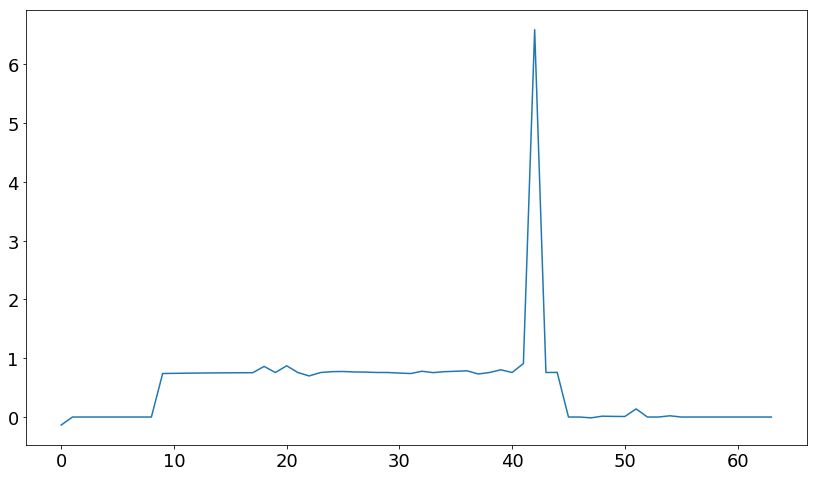

In [435]:
plt.figure(figsize=(14, 8))
plt.plot((normed_RFI[0] + signal)[:, 114])